# extract labels and training images

In [ ]:
from pytesseract import image_to_string
import cv2
import numpy as np
import re
import os

In [ ]:
images=os.listdir(".")

In [ ]:
def extract_scale_singleim(image_dir):
  '''
  input:
  image_dir: image directory

  output:
  pixel_length: int
  image_croppeded: numpy array
  '''
  image=cv2.imread(image_dir, 0)
  #crop image
  image_scale=image[670:,435:600]
  image_croppeded=image[:660,:]
  image_scale_bar=image[670:700,420:750]

  #extract scale value
  scale=image_to_string(image_scale).strip()
  scale_value=re.sub("[^0-9]","",scale)
  ##convet mm to um
  scale_value=int(scale_value)
  if scale_value<10:
      scale_value=scale_value*1000
  ##convert um to nm
  scale_value=scale_value*1000

  #extract scale bar length
  _, thresh = cv2.threshold(image_scale_bar, thresh=250, maxval=255, type=cv2.THRESH_BINARY)
  thresh=thresh.sum(axis=0)
  maximum=thresh.max()
  logic=thresh==maximum
  max_i_1=logic.argmax()
  logic=logic[max_i_1+1:]
  max_i_2=logic.argmax()
  logic=logic[max_i_2+1:]
  max_i_3=logic.argmax() + max_i_2 + max_i_1
  bar_length=max_i_3-max_i_1+3

  #how long(nm) for each pixel
  pixel_length=scale_value/bar_length
  return pixel_length, image_croppeded

In [ ]:
def extract_scale(images_dir,sufix=""):
  '''
  input:
  images_dir: str, the directories for images
  sufix: str, the sufix of image

  output:
  pixel_lengths: a list of pixel lengths
  images: a list of numpy arrays of cropped images
  '''
  image_dirs=os.listdir(images_dir)
  pixel_lengths = list()
  images = list()
  for image_dir in image_dirs:
    if re.match(sufix,image_dir) == None:
      continue
    pixel_length, image_croppeded=extract_scale_singleim(image_dir)
    pixel_lengths.append(pixel_length)
    images.append(image_croppeded)
  return pixel_lengths, images

In [ ]:
pixel_lengths, images = extract_scale(".")

In [ ]:
images[2].shape

(660, 885)

# preprocess data and extract 224x224 image patches

In [ ]:
#import basic libraries
import tensorflow as tf
import tensorboard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_hub
import keras

In [ ]:
#convert data
images=np.array(images)
images=images.reshape(images.shape[0],images.shape[1],images.shape[2],1)/255
pixel_lengths=np.array(pixel_lengths)

In [ ]:
images.shape

(366, 660, 885, 1)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, X_val_origin, y_train, y_val_origin = train_test_split(images, pixel_lengths, test_size=0.1, random_state=42,shuffle=True)
del images, pixel_lengths

def extract_224x224(images,labels,shuffle_data=True,return_original=False):
  #this function extract 224x224 patches from large image and copy labels, data will be shuffled after that
  #input:
  #images: ndarray with shape (batch,height,width,channel=1)
  #labels: ndarray with one dimension

  if shuffle_data:
    #shuffle data
    images, labels = shuffle(images, labels)

  #padding image
  x_axis_length = (images.shape[-3]//224 + 1)*224
  y_axis_length = (images.shape[-2]//224 + 1)*224
  patched_images = tf.image.resize_with_pad(images,x_axis_length,y_axis_length)

  #extract 224x224 patches
  patched_images = tf.reshape(patched_images,(-1,int(x_axis_length/224),224,int(y_axis_length/224),224,1))
  patched_images = tf.transpose(patched_images,(0,1,3,2,4,5))
  patched_images = tf.reshape(patched_images,(-1,224,224,1))
  patched_images = np.array(patched_images)

  #repeat labels
  patch_num = int(patched_images.shape[0]/images.shape[0])
  patch_labels = np.repeat(labels,patch_num)

  if return_original:
    return patched_images,patch_labels , labels, images
  else:
    return patched_images, patch_labels

In [ ]:
X_train, y_train = extract_224x224(X_train,y_train, shuffle_data=False)
X_val, y_val = extract_224x224(X_val_origin,y_val_origin, shuffle_data=False)

# transfer learning cnn

In [ ]:
base_model = keras_hub.models.Backbone.from_preset("vit_base_patch32_224_imagenet21k")

In [ ]:

converter = keras_hub.layers.ImageConverter.from_preset(
    "vit_base_patch32_224_imagenet21k",
    scale = 1
)

In [ ]:
# this model assumes all input images are 660X885
# so I need to rescale the output
@tf.keras.utils.register_keras_serializable(package="MyLayers", name="Scale")
class Scale(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__()

    # Defines the computation
    def call(self, inputs):
      output=885/tf.keras.ops.shape(inputs)[-2]
      output=tf.cast(output,tf.dtypes.float16)
      output=tf.broadcast_to(output,[tf.shape(inputs)[0],1])
      return output

@tf.keras.utils.register_keras_serializable(package="MyLayers", name="Rescale")
class Rescale(tf.keras.layers.Layer):
  #assume the scale is the last element of tensor
  #put this layer after the output layer
    def __init__(self,**kwargs):
        super().__init__()

    # Defines the computation
    def call(self, inputs):
      return tf.keras.ops.prod(inputs,axis=-1,keepdims=True)

## frozen model

In [ ]:
input_image=tf.keras.Input(shape=(None,None,None))
x=converter(input_image)
x=tf.keras.layers.RandomFlip()(x)
x=base_model(x)
wide=x[:,0,:]
x=x[:,1:,:]
x=tf.keras.layers.GlobalAveragePooling1D()(x)
x=tf.keras.ops.concatenate((x,wide),axis=-1)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(8,activation="gelu",use_bias=False,kernel_initializer="he_uniform")(x)
x=tf.keras.layers.BatchNormalization()(x)
output=tf.keras.layers.Dense(1)(x)

model=tf.keras.Model(input_image,output)

for layer in base_model.layers:
  #freeze the base model layers
  layer.trainable = False

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_image_convert… │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (ViTImageConverter) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 224, 224,  │          0 │ vi_t_image_conve… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 50, 768)   │ 87,455,232 │ random_flip_1[0]… │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 49, 768)   │          0 │ vi_t_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ get_item_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 768)       │          0 │ vi_t_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1536)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1536)      │      6,144 │ concatenate_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │     12,288 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          9 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,473,705 (333.69 MB)

 Trainable params: 15,385 (60.10 KB)

 Non-trainable params: 87,458,320 (333.63 MB)

In [ ]:
loss=tf.keras.losses.MeanSquaredLogarithmicError()
metric=tf.keras.metrics.MeanAbsolutePercentageError()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), loss=loss, metrics=[metric])

In [ ]:
#train output layer
import datetime
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def schedule(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr*0.95


In [ ]:
#fit
history=model.fit(X_train,
                  [y_train],
                  epochs=100,
                  validation_data=(X_val, y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,start_from_epoch=40),
                      tf.keras.callbacks.LearningRateScheduler(schedule),
                      tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1),
                      tf.keras.callbacks.ModelCheckpoint('../best_model_frozen.keras',save_best_only=True)],
                  batch_size= 128)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 523ms/step - loss: 6.9510 - mean_absolute_percentage_error: 76.8355 - val_loss: 1.7673 - val_mean_absolute_percentage_error: 56.7405 - learning_rate: 0.5000
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - loss: 2.5521 - mean_absolute_percentage_error: 63.7977 - val_loss: 1.0815 - val_mean_absolute_percentage_error: 47.4941 - learning_rate: 0.5000
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - loss: 1.9664 - mean_absolute_percentage_error: 64.2140 - val_loss: 0.8545 - val_mean_absolute_percentage_error: 48.7547 - learning_rate: 0.5000
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - loss: 1.6988 - mean_absolute_percentage_error: 66.2529 - val_loss: 0.7501 - val_mean_absolute_percentage_error: 51.2556 - learning_rate: 0.5000
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - loss: 1.5473 - mean_absolute_percentage_error: 68.5803 - val_loss: 0.6910 - val_mean_absolute_percentage_error: 53.2109 - learning_rate: 0.5000
Epoc

In [ ]:
model=tf.keras.models.load_model("../best_model_frozen.keras")

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_image_convert… │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (ViTImageConverter) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 224, 224,  │          0 │ vi_t_image_conve… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 50, 768)   │ 87,455,232 │ random_flip_1[0]… │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 49, 768)   │          0 │ vi_t_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ get_item_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 768)       │          0 │ vi_t_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1536)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1536)      │      6,144 │ concatenate_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │     12,288 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          9 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,473,707 (333.69 MB)

 Trainable params: 87,470,617 (333.67 MB)

 Non-trainable params: 3,088 (12.06 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
#evaluate model with images
def display_images(images, titles):
  #this function is transformed from sklearn website
  import matplotlib.pyplot as plt
  number = len(images)
  #specify column number and row number
  if number%4 == 0:
    n_row = number//4
  else:
    n_row = number//4+1
  n_col = 4
  #plot figure
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
  for i in range(number):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

In [ ]:
prediction = model.predict(X_train)
prediction = pd.DataFrame({'pred':prediction.reshape(-1),'truth':y_train})
prediction = prediction.apply(lambda x : abs((x['pred']-x['truth'])/x['truth'])*100,axis=1)

124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step


In [ ]:
sorted_index=pd.DataFrame(prediction).sort_values(0).index

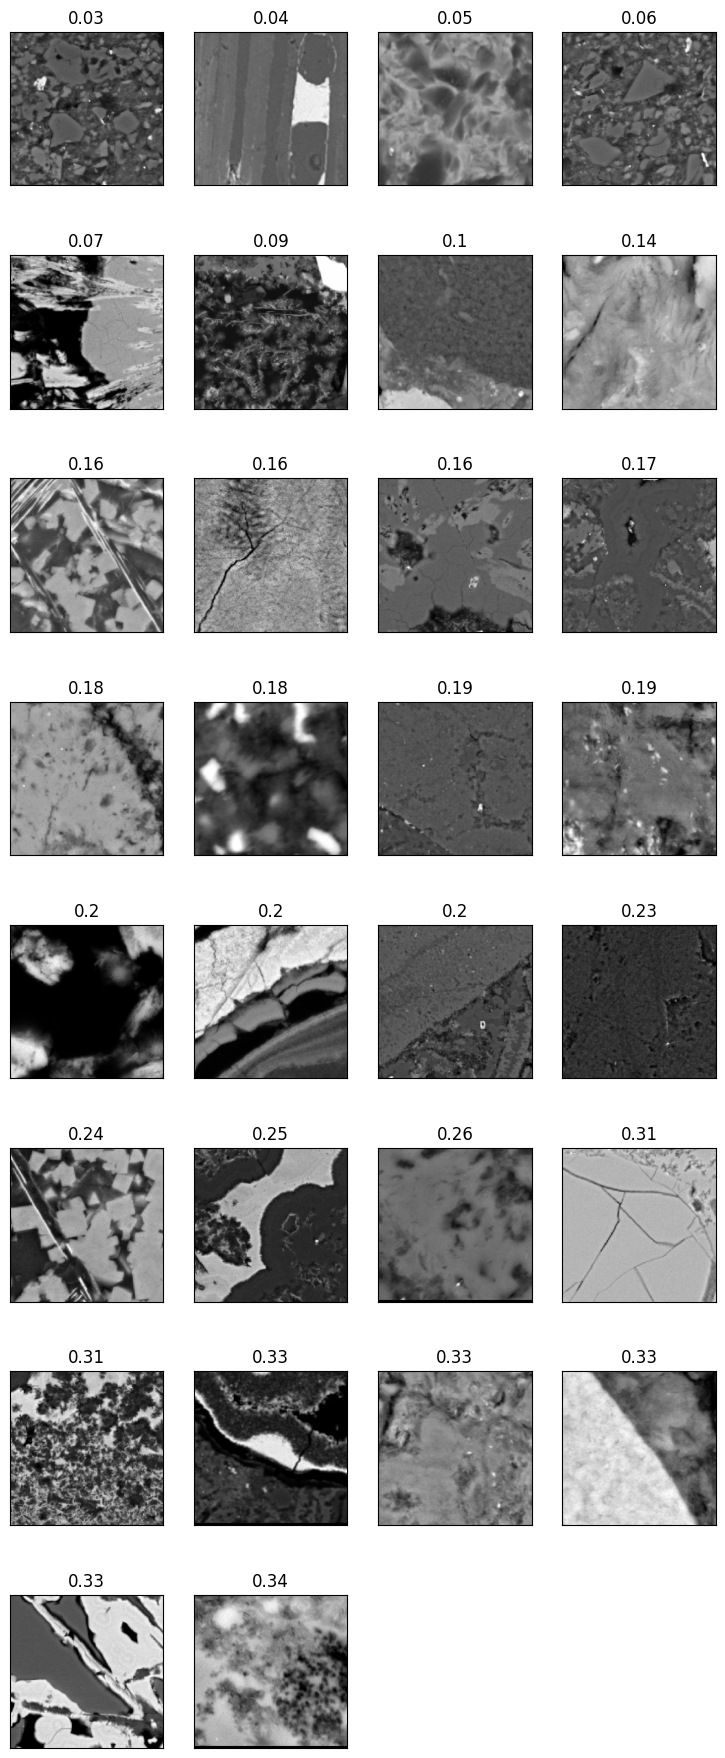

In [ ]:
#best 30 images
best_30_index = sorted_index[:30]
display_images(X_train[best_30_index],list(prediction[best_30_index].round(2)))

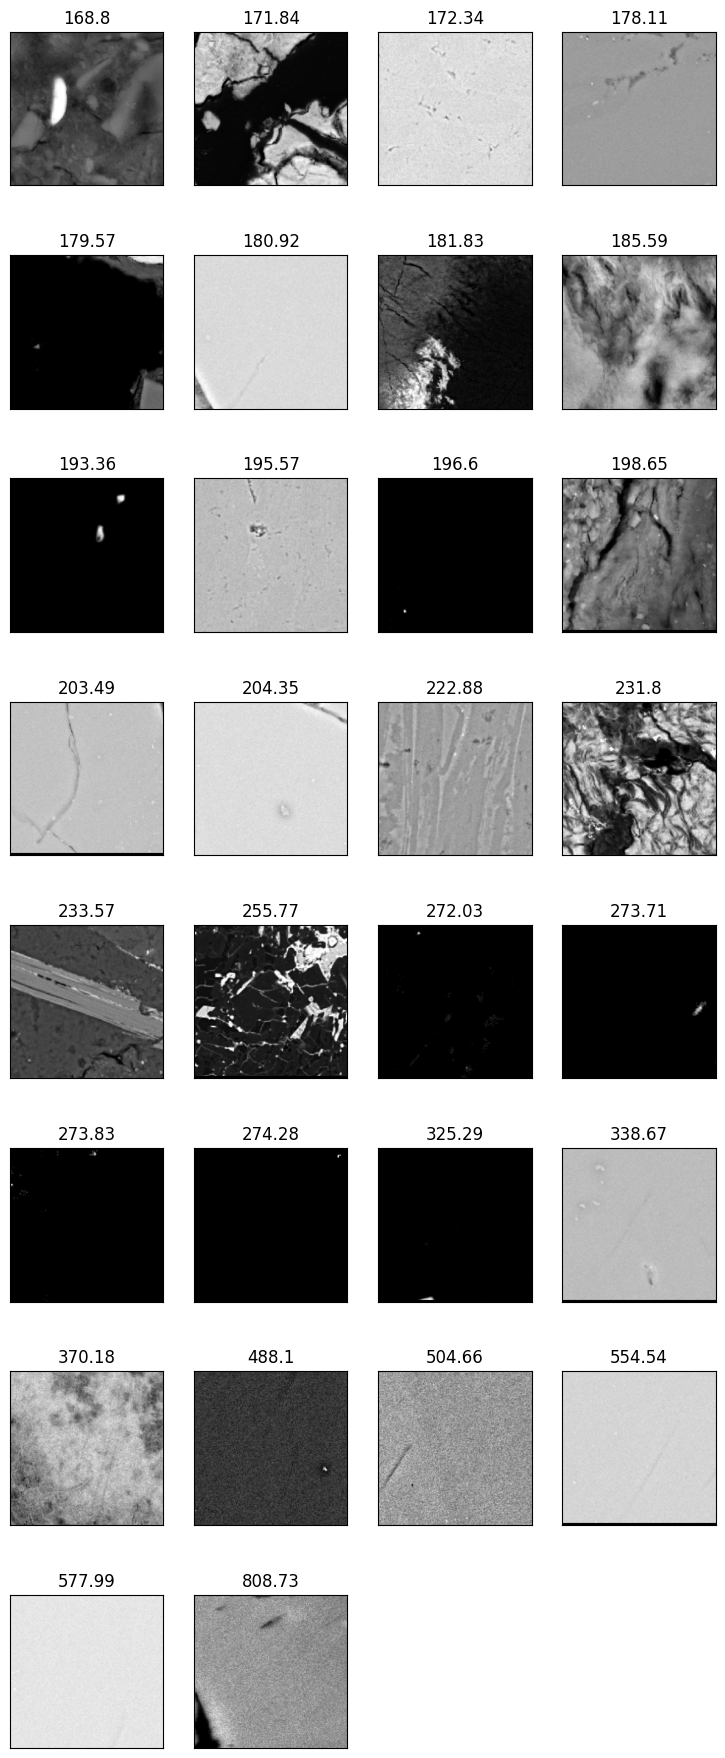

In [ ]:
#worst 30 images
worst_30_index = sorted_index[-30:]
display_images(X_train[worst_30_index],list(prediction[worst_30_index].round(2)))

In [ ]:
#build model with confidence score
input = model.input
x = model.layers[-2].output
x = tf.keras.layers.Dense(8,activation="gelu",use_bias=False,kernel_initializer="he_uniform",name="confidence_dense")(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(1,name="confidence_score",activation="sigmoid")(x)
confidence_model = tf.keras.Model(model.input,[model.output,output])
for layer in model.layers:
  layer.trainable = False
confidence_model.summary()

In [ ]:
#train the confidence score model
loss=tf.keras.losses.MeanSquaredError()
metric=tf.keras.metrics.MeanAbsoluteError()
confidence_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), loss=[None,loss], metrics=[None,metric])

In [ ]:
#train output layer
import datetime
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def schedule(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr*0.95

In [ ]:
#prepare validation labels
prediction_val = model.predict(X_val)
prediction_val = pd.DataFrame({'pred':prediction_val.reshape(-1),'truth':y_val})
prediction_val = prediction_val.apply(lambda x : abs((x['pred']-x['truth'])/x['truth'])*100,axis=1)

#prepocess labels
from sklearn.preprocessing import minmax_scale
confidence_score = minmax_scale(1/prediction)
confidence_score_val = minmax_scale(1/prediction_val)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


In [ ]:
#fit
history=confidence_model.fit(X_train,
                  [y_train,confidence_score],
                  validation_data=(X_val, [y_val,confidence_score_val]),
                  epochs=100,
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,start_from_epoch=10),
                      tf.keras.callbacks.LearningRateScheduler(schedule),
                      tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1),
                      tf.keras.callbacks.ModelCheckpoint('../best_model_confidence.keras',save_best_only=True)],
                  batch_size= 128)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 549ms/step - confidence_score_mean_absolute_error: 0.1665 - loss: 0.0569 - val_confidence_score_mean_absolute_error: 0.0738 - val_loss: 0.0158 - learning_rate: 0.5000
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - confidence_score_mean_absolute_error: 0.0523 - loss: 0.0042 - val_confidence_score_mean_absolute_error: 0.0550 - val_loss: 0.0138 - learning_rate: 0.5000
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - confidence_score_mean_absolute_error: 0.0367 - loss: 0.0024 - val_confidence_score_mean_absolute_error: 0.0482 - val_loss: 0.0136 - learning_rate: 0.5000
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - confidence_score_mean_absolute_error: 0.0296 - loss: 0.0017 - val_confidence_score_mean_absolute_error: 0.0452 - val_loss: 0.0137 - learning_rate: 0.5000
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - confidence_score_mean_absolute_error: 0.0256 - loss: 0.0015 - val_confidence_score_mean_absolute_error: 0.

## create the model for prediction

In [ ]:
model=tf.keras.models.load_model("../best_model_confidence.keras")

In [ ]:
#the input data should only have one instance
input_image=tf.keras.Input(shape=(None,224,224,1),name="input_image")
original_image=tf.keras.Input(shape=(None,None,None),name="original_image")
x=tf.keras.ops.reshape(input_image,(-1,224,224,1))
width=Scale()(original_image)
x,score = model(x)
score = tf.keras.ops.reshape(score,(1,-1))
weights = tf.keras.activations.softmax(score)
x = tf.keras.ops.reshape(x,(-1,1))
x = weights @ x
x=tf.keras.ops.concatenate([x,width],-1)
output=Rescale()(x)
confidence_score=tf.keras.ops.average(score,axis=-1)

model=tf.keras.Model([input_image,original_image],[output,confidence_score],name="model_for_prediction")
model.summary()

Model: "model_for_prediction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, None, 224, │          0 │ -                 │
│ (InputLayer)        │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_31          │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ [(None, 1),       │ 87,473,810 │ reshape_31[0][0]  │
│ (Functional)        │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_32          │ (1, None)         │          0 │ functional_3[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_177         │ (1, None)         │          0 │ reshape_32[0][0]  │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_33          │ (None, 1)         │          0 │ functional_3[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_image      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matmul_5 (Matmul)   │ (1, 1)            │          0 │ softmax_177[0][0… │
│                     │                   │            │ reshape_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_12 (Scale)    │ (None, 1)         │          0 │ original_image[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (1, 2)            │          0 │ matmul_5[0][0],   │
│ (Concatenate)       │                   │            │ scale_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescale_5 (Rescale) │ (1, 1)            │          0 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_9 (Average) │ (1)               │          0 │ reshape_32[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,473,810 (333.69 MB)

 Trainable params: 87,455,321 (333.62 MB)

 Non-trainable params: 18,489 (72.22 KB)

In [ ]:
model.export("../model_for_prediction")

# implement model

In [ ]:
model = tf.saved_model.load("../model_for_prediction")

In [ ]:
confidence_model=tf.saved_model.load("../model_confidence")

In [ ]:
def predict(image,rescale=True,convert_image=True):
  #if convert_image = True, input image shape (heighth,width)
  if rescale:
    image=np.array(image)
    image=image/255

  if convert_image:
    image = image.reshape(1,image.shape[0],image.shape[1],1)

  patched_image, _ = extract_224x224(image,np.array([0]),shuffle_data=False)
  patched_image = patched_image.reshape(1,patched_image.shape[0],patched_image.shape[1],patched_image.shape[2],1)
  return model.serve([patched_image,image])

def predict_batch(images,rescale=True,convert_image=True):
  #if convert_image = True, input: an iterable object,the elements are images with shape (heighth,width)
  output = list()
  for i in range(len(images)):
    image = images[i]

    if not convert_image:
      image = image.reshape(1,image.shape[0],image.shape[1],1)

    output.append(predict(image,rescale=rescale,convert_image=convert_image))
    predictions,scores = zip(*output)
    predictions = np.array(predictions)
    scores = np.array(scores)
  return predictions, scores

# Evaluate Model

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/A.tif", 0)

In [ ]:
image.shape

(770, 1024)

In [ ]:
predict(image)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[374.25476]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03810989], dtype=float32)>]

In [ ]:
251*318.19617/1000

79.86723866999999

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/BAT405_001.tif", 0)

In [ ]:
predict(image)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[119.55911]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.04129773], dtype=float32)>]

In [ ]:
756*119.55911/1000

90.38668716000001

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/Large_area-map-Verios.TIF", 0)

In [ ]:
predict(image)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[462.79443]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.05245429], dtype=float32)>]

In [ ]:
101*462.79443/1000

46.74223743

## consistancy test

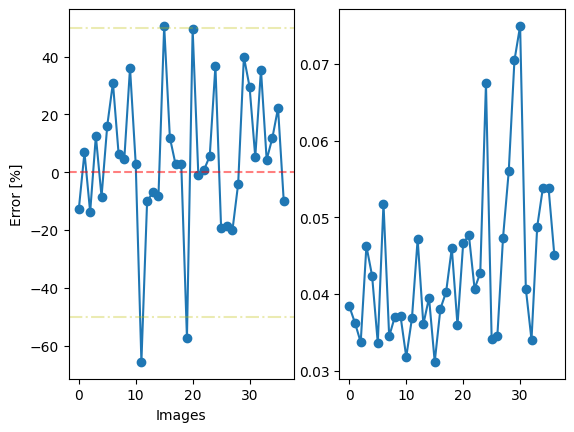

In [ ]:
predictions, scores = predict_batch(X_val_origin,convert_image=False,rescale=False)
predictions = pd.DataFrame({'pred':predictions.reshape(-1),'truth':y_val_origin})
predictions = predictions.apply(lambda x : ((x['pred']-x['truth'])/x['truth'])*100,axis=1)
plt.subplot(1,2,1)
plt.plot(predictions, '-o')
plt.xlabel('Images')
plt.ylabel('Error [%]')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=50, color='y', linestyle='-.', alpha=0.3)
plt.axhline(y=-50, color='y', linestyle='-.', alpha=0.3)
plt.subplot(1,2,2)
scores = pd.DataFrame(scores)
plt.plot(scores, '-o')
plt.show()

compared with compressing image\
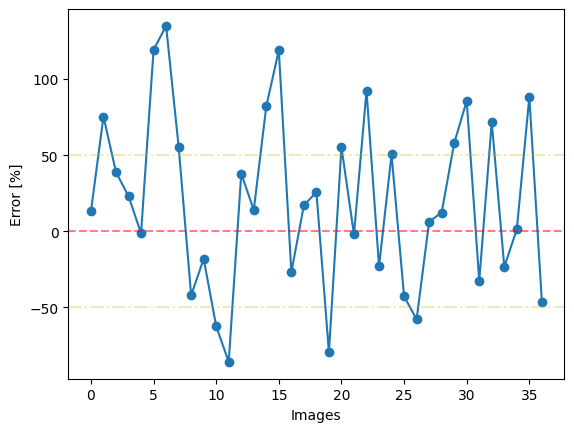

In [ ]:
predictions.abs().mean()

18.437134947328314

compressing image\
55.063481

In [ ]:
predictions.std()

24.98033794885561

compressing image\
64.076647

# visualize confidence

In [ ]:
y_pred, scores = confidence_model.serve(X_val)

In [ ]:
y_pred, scores = np.array(y_pred), np.array(scores)

In [ ]:
titles = [f"truth: {val}\n pred: {pred}\n confidence: {score}" for val,pred,score in zip(y_val.round(2),y_pred.round(2),scores.round(2))]

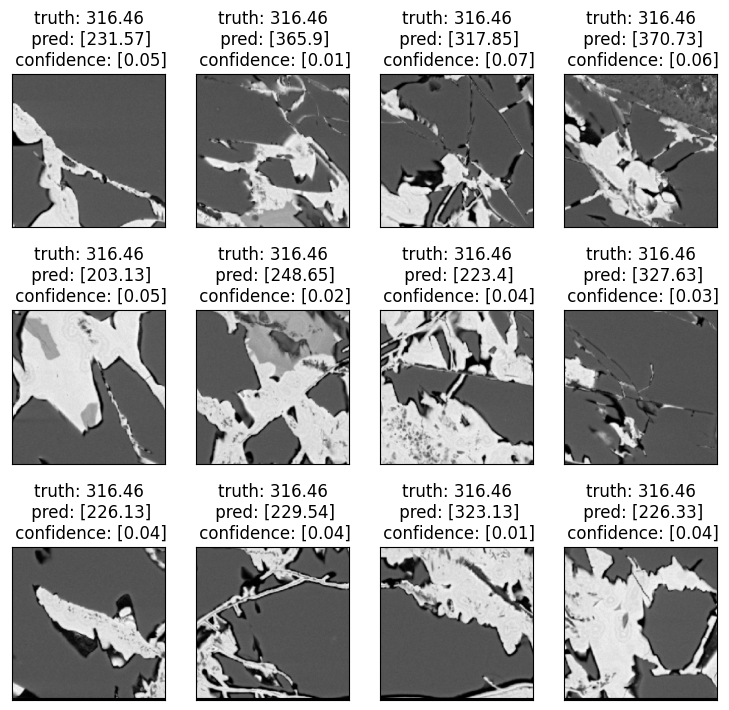

In [ ]:
display_images(X_val[:12],titles[:12])

In [ ]:
predict(X_val_origin[0],rescale=False)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[286.50568]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03891108], dtype=float32)>]

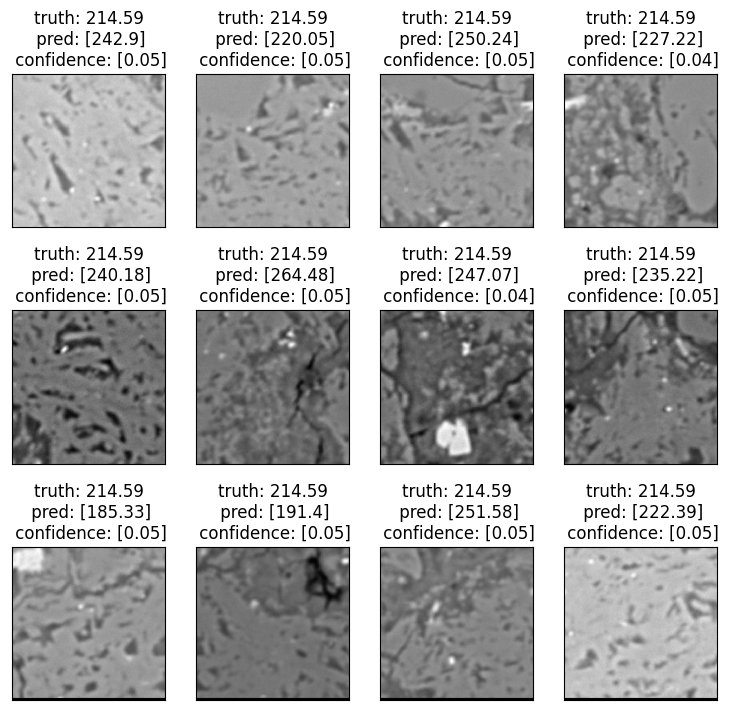

In [ ]:
display_images(X_val[12:24],titles[12:24])

In [ ]:
predict(X_val_origin[1],rescale=False)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[231.83347]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03856784], dtype=float32)>]

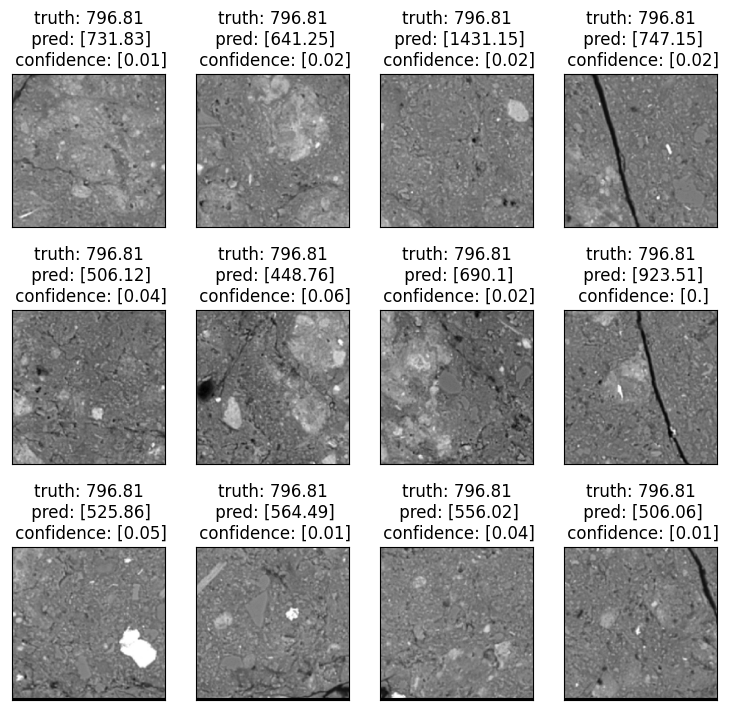

In [ ]:
display_images(X_val[-12:],titles[-12:])

In [ ]:
predict(X_val_origin[-1],rescale=False)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[699.6757]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03871996], dtype=float32)>]

# attention rollout map [TODO]

In [ ]:
seq = model.layers[:4]
attention_prediction = tf.keras.Sequential(seq)

ValueError: Sequential model 'sequential' has already been configured to use input shape (None, None, 224, 224, 1). You cannot add a different Input layer to it.

In [ ]:
attention_prediction.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vi_t_image_converter            │ (None, 224, 224, 3)    │             0 │
│ (ViTImageConverter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_13 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 50, 768)        │    87,455,232 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,455,232 (333.62 MB)

 Trainable params: 87,455,232 (333.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
attention_output=attention_prediction.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


In [ ]:
model.layers[3].layers[-1].encoder_layers[0].mha

<ViTEncoder name=vit_encoder, built=True>

In [ ]:
model.layers[3].layers[-1].weights

[<Variable path=vit_encoder/tranformer_block_1/ln_1/gamma, shape=(768,), dtype=float32, value=[0.05967442 0.15965936 0.16814008 0.08800096 0.12828965 0.05542477
  0.11550008 0.18144831 0.19916369 0.18839933 0.10004942 0.2145762
  0.18949422 0.18449044 0.20716023 0.12233839 0.15785281 0.17183979
  0.13168783 0.20835668 0.1891575  0.05211667 0.12093622 0.19563675
  0.12218945 0.10641309 0.13291691 0.14067863 0.11350758 0.19074708
  0.1346639  0.19314997 0.18952079 0.19094141 0.15365003 0.17192645
  0.19294974 0.20327593 0.17148453 0.12388868 0.17999414 0.1434129
  0.15098763 0.19814722 0.22170436 0.11455257 0.15100996 0.06799219
  0.18049054 0.28443706 0.24079235 0.1732035  0.13817418 0.08976421
  0.10594165 0.19905421 0.18995102 0.12907122 0.21211539 0.15020315
  0.203505   0.15465996 0.11218411 0.15710205 0.09881924 0.14748535
  0.23122706 0.2254305  0.13772742 0.13655654 0.15375322 0.1805431
  0.18750052 0.05656478 0.19714268 0.044934   0.10195977 0.14511402
  0.14337415 0.20255078 0.

In [ ]:
class ViTEncoderBlock(keras_hub.src.models.vit.vit_layers.ViTEncoderBlock):
  def call(self, inputs):
        x = self.layer_norm_1(inputs)
        x, score = self.mha(x, x, return_attention_scores = True) #return attention score
        x = self.dropout(x)
        x = x + inputs

        y = self.layer_norm_2(x)
        y = self.mlp(y)

        return x + y, score #return score

class MyVitEncoder(keras_hub.src.models.vit.vit_layers.ViTEncoder):
  def __init__(
        self,
        **kwargs
    ):
        super().__init__(**kwargs)

  def build(self, input_shape):
        self.encoder_layers = []
        for i in range(self.num_layers):
            encoder_block = ViTEncoderBlock(
                num_heads=self.num_heads,
                hidden_dim=self.hidden_dim,
                mlp_dim=self.mlp_dim,
                dropout_rate=self.dropout_rate,
                use_mha_bias=self.use_mha_bias,
                use_mlp_bias=self.use_mlp_bias,
                attention_dropout=self.attention_dropout,
                layer_norm_epsilon=self.layer_norm_epsilon,
                dtype=self.dtype_policy,
                name=f"tranformer_block_{i + 1}",
            )
            encoder_block.build((None, None, self.hidden_dim))
            self.encoder_layers.append(encoder_block)
        self.dropout = keras.layers.Dropout(
            self.dropout_rate, dtype=self.dtype_policy, name="dropout"
        )
        self.layer_norm = keras.layers.LayerNormalization(
            epsilon=self.layer_norm_epsilon,
            dtype=self.dtype_policy,
            name="ln",
        )
        self.layer_norm.build((None, None, self.hidden_dim))
        self.built = True

  def call(self, inputs):
        score_list = [] # the score list
        x = self.dropout(inputs)
        for i in range(self.num_layers):
            x, score = self.encoder_layers[i](x) #return score
            score_list.append(score)
        x = self.layer_norm(x)
        return x,score_list



In [ ]:
config=model.layers[3].layers[-1].get_config()

In [ ]:
my_encoder = MyVitEncoder(**config)

In [ ]:
my_encoder.get_config()

{'name': 'vit_encoder',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'num_layers': 12,
 'num_heads': 12,
 'hidden_dim': 768,
 'mlp_dim': 3072,
 'use_mha_bias': True,
 'use_mlp_bias': True,
 'dropout_rate': 0.0,
 'attention_dropout': 0.0,
 'layer_norm_epsilon': 1e-06}

In [ ]:
#make new model to get attention rollout
#modify the vit backbone
input = model.layers[3].input
output = my_encoder(model.layers[3].layers[-2].output)
rollout_vit = tf.keras.Model(input, output,name="rollout_vit",)
#reconstruct the model
input = model.input
output = rollout_vit(model.layers[2].output)
rollout_model = tf.keras.Model(input, output,name="rollout_model")

In [ ]:
rollout_model.summary()

Model: "rollout_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, None, None,     │             0 │
│                                 │ None)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_image_converter            │ (None, 224, 224, 3)    │             0 │
│ (ViTImageConverter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_13 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rollout_vit (Functional)        │ [(None, 50, 768),      │    87,455,232 │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50)]    │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,455,232 (333.62 MB)

 Trainable params: 87,455,232 (333.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#transfer weights
rollout_model.layers[3].layers[-1].set_weights(model.layers[3].layers[-1].get_weights())

In [ ]:
rollout_model.layers[3].layers[-1].get_weights()[0]

array([0.05967442, 0.15965936, 0.16814008, 0.08800096, 0.12828965,
       0.05542477, 0.11550008, 0.18144831, 0.19916369, 0.18839933,
       0.10004942, 0.2145762 , 0.18949422, 0.18449044, 0.20716023,
       0.12233839, 0.15785281, 0.17183979, 0.13168783, 0.20835668,
       0.1891575 , 0.05211667, 0.12093622, 0.19563675, 0.12218945,
       0.10641309, 0.13291691, 0.14067863, 0.11350758, 0.19074708,
       0.1346639 , 0.19314997, 0.18952079, 0.19094141, 0.15365003,
       0.17192645, 0.19294974, 0.20327593, 0.17148453, 0.12388868,
       0.17999414, 0.1434129 , 0.15098763, 0.19814722, 0.22170436,
       0.11455257, 0.15100996, 0.06799219, 0.18049054, 0.28443706,
       0.24079235, 0.1732035 , 0.13817418, 0.08976421, 0.10594165,
       0.19905421, 0.18995102, 0.12907122, 0.21211539, 0.15020315,
       0.203505  , 0.15465996, 0.11218411, 0.15710205, 0.09881924,
       0.14748535, 0.23122706, 0.2254305 , 0.13772742, 0.13655654,
       0.15375322, 0.1805431 , 0.18750052, 0.05656478, 0.19714

In [ ]:
ops=tf.keras.ops
def attention_rollout_map(image, attention_score_list, model_type = "usal"):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = ops.stack(attention_score_list)
    attn_mat = ops.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = ops.mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = ops.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / ops.sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = ops.convert_to_numpy(aug_attn_mat)

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), [image.shape[1],image.shape[0]], interpolation = cv2.INTER_NEAREST)[..., np.newaxis]
    result = mask
    return result

In [ ]:
converter = keras_hub.layers.ImageConverter.from_preset(
    "vit_base_patch32_224_imagenet21k"
)

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/Large_area-map-Verios.TIF", 0)
image=image.reshape(1,image.shape[0],image.shape[1],1)
ver_output, score_list=rollout_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [ ]:
image = np.array(converter(image))[0,:,:,0].reshape(224,224,1)

In [ ]:
mask=attention_rollout_map(image, score_list)

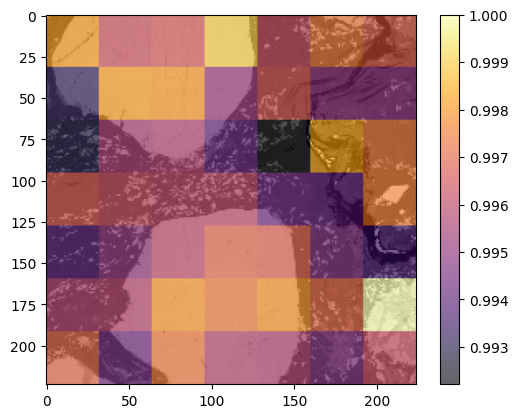

In [ ]:
plt.imshow(image,cmap="grey")
plt.imshow(mask,cmap="inferno", alpha = 0.6)
plt.colorbar()
plt.show()

In [ ]:
#double check my weight
input1 = model.input
input2 = model.layers[4].input
output = model.layers[-1].output
verification_model = tf.keras.Model(inputs=[input1,input2],outputs=output, name="verification_model")

In [ ]:
verification_model.summary()

Model: "verification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_9CLONE │ (None, 50, 768)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ keras_tensor_9CL… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 8)         │      6,144 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_23[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │          9 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale (Scale)       │ (None, 1)         │          0 │ input_layer_16[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 2)         │          0 │ dense_24[1][0],   │
│ (Concatenate)       │                   │            │ scale[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescale (Rescale)   │ (None, 1)         │          0 │ concatenate_13[1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,257 (36.16 KB)

 Trainable params: 7,705 (30.10 KB)

 Non-trainable params: 1,552 (6.06 KB)

In [ ]:
verification_model.predict([image,ver_output])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[322.01215]], dtype=float32)

In [ ]:
model.predict(image)

I0000 00:00:1758708696.452764   10282 service.cc:152] XLA service 0x7f17100ba010 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758708696.452786   10282 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-09-24 18:11:36.497176: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1758708697.155296   10282 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[247.59666]], dtype=float32)

In [ ]:
tf.keras.utils.clear_session()

## other images

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/BAT405_001.tif", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)
ver_output, score_list=rollout_model.predict(image)
image = np.array(converter(image))[0,:,:,0].reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [ ]:
mask=attention_rollout_map(image, score_list)

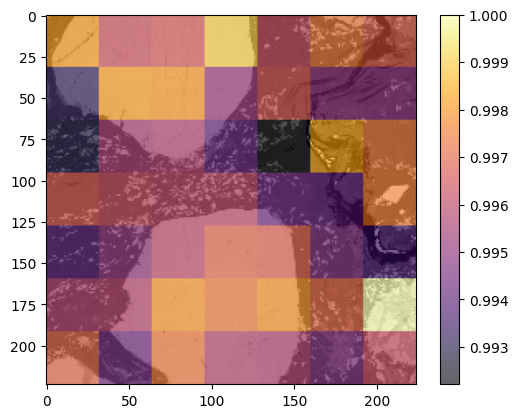

In [ ]:
plt.imshow(image,cmap="grey")
plt.imshow(mask,cmap="inferno", alpha = 0.6)
plt.colorbar()
plt.show()

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/A.tif", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)
ver_output, score_list=rollout_model.predict(image)
image = np.array(converter(image))[0,:,:,0].reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [ ]:
mask=attention_rollout_map(image, score_list)

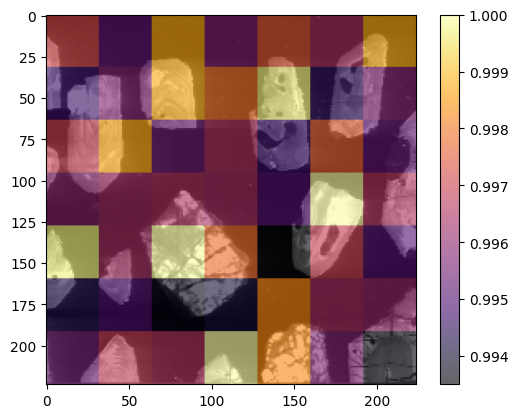

In [ ]:
plt.imshow(image,cmap="grey")
plt.imshow(mask,cmap="inferno", alpha = 0.6)
plt.colorbar()
plt.show()